# Nanosecond #

_High_-tech watches at a _low_ price

In [1]:
%matplotlib inline
import sympy
from pprint import pprint

### Utility functions ###

See docstrings

In [2]:
def plot_sym_func(func, range=(-10, 10), **kwargs):
    """
    Plot a symbolic function in a given range.
    
    A symbolic function is an ordinary Python callable that returns meaningful symbolic result given a symbolic parameter
    """
    # TODO: co_varnames includes all variables, not just parameters; should use inspect
    kwargs.setdefault("xlabel", func.__code__.co_varnames[0])
    kwargs.setdefault("ylabel", "{.__name__}({})".format(func, kwargs["xlabel"]))
    
    x = sympy.Dummy("x")
    return sympy.plotting.plot(func(x), (x, *range), **kwargs) # 3.5+

def nsols(expr, guess_range, **solvekw):
    """
    Yield every solution found in a given range.
    
    Solutions are not guaranteed to be unique (and probably aren't)
    """
    for guess in guess_range:
        try: 
            yield sympy.nsolve(expr, guess, **solvekw)
        except (ValueError, OverflowError):
            # TODO: verbose
            pass

def maximize(expr, var, guess_range, **solvekw):
    """
    Maximize a symbolic expression for ``var``.
    
    The first and second derivative of ``expr`` must be defined
    """
    d1 = expr.diff(var)
    d2 = d1.diff(var)
    
    return max((peak for peak in nsols(d1, guess_range, **solvekw) 
                if d2.subs(var, peak) < 0),
               key=lambda peak: expr.subs(var, peak))

# x = sympy.Dummy("x")
# print(maximize(-(x-5)**2, x, range(-100, 100, 10)))

### Marginal watch production per hour ###

Returns watch production per hour, given a mass of nanobots.  
After a certain point (`peak`), we get diminishing returns because the nanobots get crowded over the watches and the number of possible things a nanobot could do to aid production begin to diminish.

`nm` means nanobot mass in grams.  `nm` is the fundamental variable of labor, all other labor is derived from the rate of watch production, and thus from `nm`.

Also note how we define relevant configuration variables such as `init` locally unless they have some global meaning.

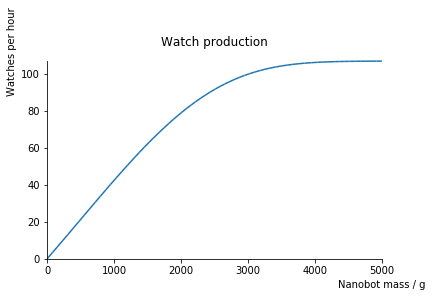

In [3]:
def marg_watch_prod(nm):
    # Initial marginal production: marg_watch_prod(0)
    # Essentially watches / hour for 1 gram of nanobots
    init = 1/24
    
    # Point of diminishing marginal returns
    peak = 500
    
    # Tightness around the peak
    # TODO: come up with a good value for this automagically
    squeeze = 1/2000
    
    x = sympy.Dummy("x")
    shape = sympy.exp(squeeze * x) * sympy.exp(-sympy.exp(squeeze * x))
    
    return init * shape.subs(x, nm - peak) / shape.subs(x, -peak)

def watch_prod(nm):
    x = sympy.Dummy("x")
    return sympy.integrate(marg_watch_prod(x), (x, 0, nm))

plot_sym_func(
    marg_watch_prod, (0, 5000),
    title="Marginal watch production",
    xlabel="Nanobot mass / g", ylabel="Watches per hour"
)

plot_sym_func(
    watch_prod, (0, 5000),
    title="Watch production",
    xlabel="Nanobot mass / g", ylabel="Watches per hour"
)

### Nanobot loss per hour ###

Nanobots are powered by radioactive decay and we do not know how to refuel them.  Nanobots may be lost in other ways too, for example by getting stuck in the watches.  Both of these issues might be worked around with a better understanding of nanobots, a further incentive for R&D.

Loss through watches is dependant on production, loss through radioactive decay is dependant on time.

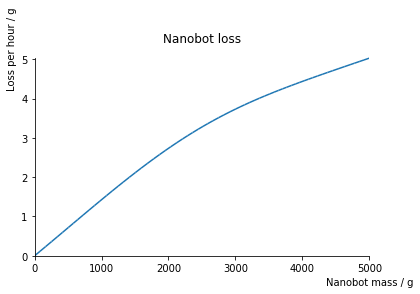

In [4]:
def nano_loss(nm):
    # Half-life of nanobots in days
    half_life = 50
    
    # Mass of nanobots stuck in each watch
    nanobot_loss = 1/50
    
    # Decayed nanobots after an hour
    decayed = nm - nm * (1/2) ** (1 / (24 * half_life))
    
    # Nanobots stuck in watches after an hour
    stuck = watch_prod(nm) * nanobot_loss
    
    return decayed + stuck

plot_sym_func(
    nano_loss, (0, 5000),
    title="Nanobot loss",
    xlabel="Nanobot mass / g", ylabel="Loss per hour / g"
)

### Costs ###

`hourly_costs` computes the costs involved in producing the watches in an hour, given the working mass of nanobots.  

This is an aggregate of several sources of cost:

- Raw materials used by nanobots to create watches
- Workers needed to keep the system running and pack created watches
- Cost to replace lost nanobots (see `nano_loss`)
- Fixed costs

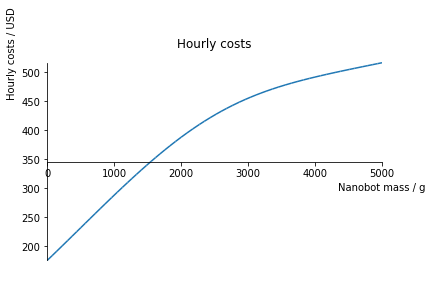

In [5]:
# fixed costs in a year
FIXED_COSTS = (
    150_000 +    # rent/maintenance
    50_000 * 20  # rough estimate of salaries of fixed workers
)

# Hours of work per week
WORK_WEEK = 18 * 7

def hourly_costs(nm):
    # Cost of raw materials per watch, USD
    materials = 1
    
    # Watches processed by a worker / hour
    worker_productivity = 50
    
    # Salary of watch-workers / hour, USD
    worker_salary = 15
    
    # Average nanobot price / gram, USD
    nanobot_price = 40
    
    watches = watch_prod(nm)
    
    # TODO: Should we use integer division?
    workers = watches / worker_productivity
    
    return (materials * watches + 
            workers * worker_salary + 
            nanobot_price * nano_loss(nm) +
            FIXED_COSTS / 52 / WORK_WEEK)

plot_sym_func(
    hourly_costs, (0, 5000),
    title="Hourly costs",
    xlabel="Nanobot mass / g", ylabel="Hourly costs / USD"
)

### Watch Demand ###

Watches bought per work-hour when sold at the given price

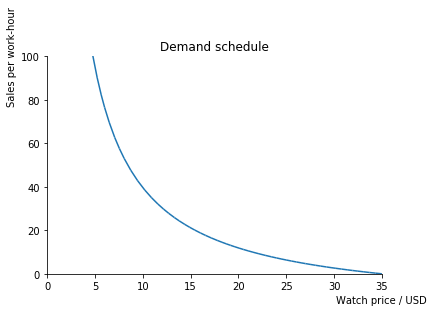

In [6]:
def watch_demand(unit_price):
    # Demand at a given price: (price, purchased per **week**)
    known_demand = (10, 5000)
    # The price at which the watch is too expensive to generate any demand
    too_expensive = 35
    
    x = sympy.Dummy("x")
    shape = 1/x
    shape -= shape.subs(x, too_expensive)
    
    p, d = known_demand
    return shape.subs(x, unit_price) * d / shape.subs(x, p) / WORK_WEEK

def demand_inv(watches):
    price = sympy.Dummy("price")
    watches_ = sympy.Dummy("watches")
    return sympy.solve(watch_demand(price) - watches_, price)[0].subs(watches_, watches)

plot_sym_func(
    watch_demand, (0, 35), ylim=(0, 100),
    title="Demand schedule",
    xlabel="Watch price / USD", ylabel="Sales per work-hour"
)

### Profit ###

Profit per hour, given a working mass of nanobots.

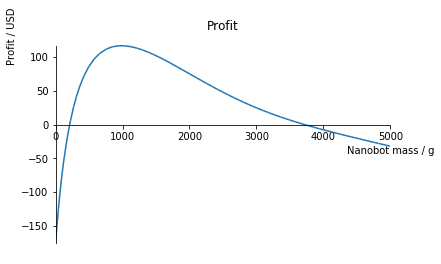

In [7]:
def profit(nm):
    wp = watch_prod(nm)
    return wp * demand_inv(wp) - hourly_costs(nm)

plot_sym_func(
    profit, (0, 5000),
    title="Profit",
    xlabel="Nanobot mass / g", ylabel="Profit / USD"
)

### Analysis ###

Determine the ideal production level to maximize profit, and find related information.

In [8]:
def stats(nm):
    hourly_prod = watch_prod(nm)
    hourly_profit = profit(nm)
    
    price = demand_inv(hourly_prod)
    contrib = hourly_profit / hourly_prod
    
    return {
        "nm": nm,
        "prod": hourly_prod,
        "profit": hourly_profit,
        "price": price,
        "contrib": contrib,
        "hourly_costs": hourly_costs(nm),
        "break_even": FIXED_COSTS / contrib / hourly_prod / WORK_WEEK
    }

def maximize_profit(guess_range, *, solver="anewton"):
    nm = sympy.Dummy("nm")
    return stats(maximize(profit(nm), nm, guess_range, solver=solver))

def non_profit(guess_range, *, solver="anewton"):
    nm = sympy.Dummy("nm")
    
    return stats(max(nsols(profit(nm), guess_range, solver=solver)))

print("max profit:")
pprint(maximize_profit(range(0, 2000, 500)))
print("non-profit:")
pprint(non_profit(range(0, 2000, 500)))

max profit:
{'break_even': 78.2676123572052,
 'contrib': 2.79323808905641,
 'hourly_costs': 285.903051206256,
 'nm': 983.322209198295,
 'price': 9.64151851846860,
 'prod': 41.7481518394532,
 'profit': 116.612527865671}
non-profit:
{'break_even': -1.36070849818929e+15,
 'contrib': -6.36169982698796e-14,
 'hourly_costs': 482.862357407662,
 'nm': 3720.10162865152,
 'price': 4.57967148331769,
 'prod': 105.436025087514,
 'profit': -6.70752342557535e-12}
